In [2]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector

from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor

import itertools

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('cardox.csv')
df.index = pd.to_datetime(df.date, format='%Y-%m-%d')
df.drop('date', axis=1, inplace=True)

In [4]:
df.shape

(729, 1)

In [5]:
df

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86
...,...
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 1958-03-01 to 2018-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   729 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


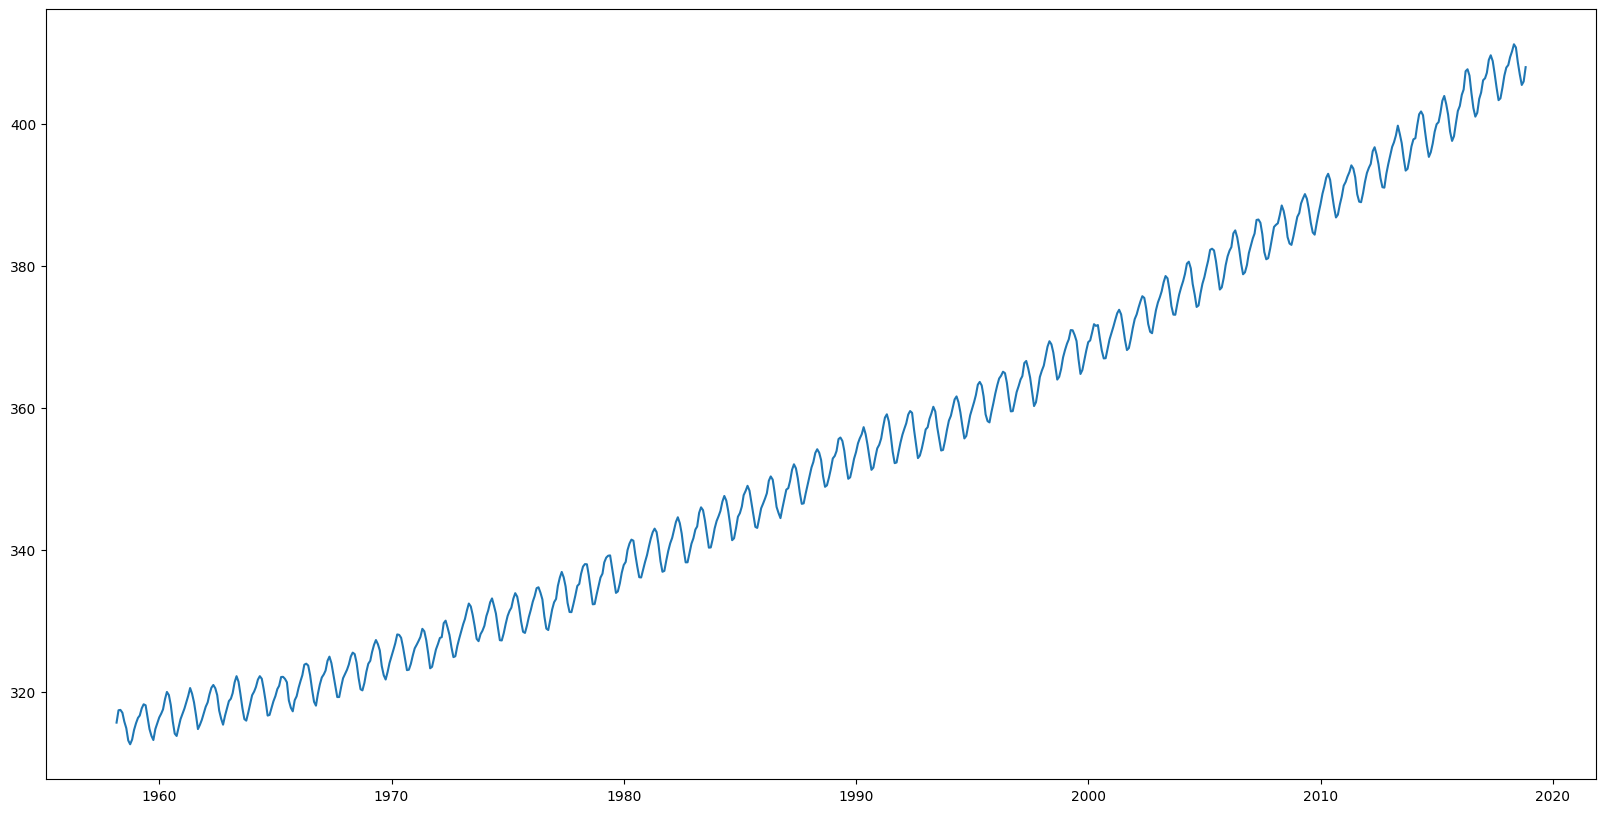

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(df)

Text(0.5, 0.98, 'Мультиплікатива модель')

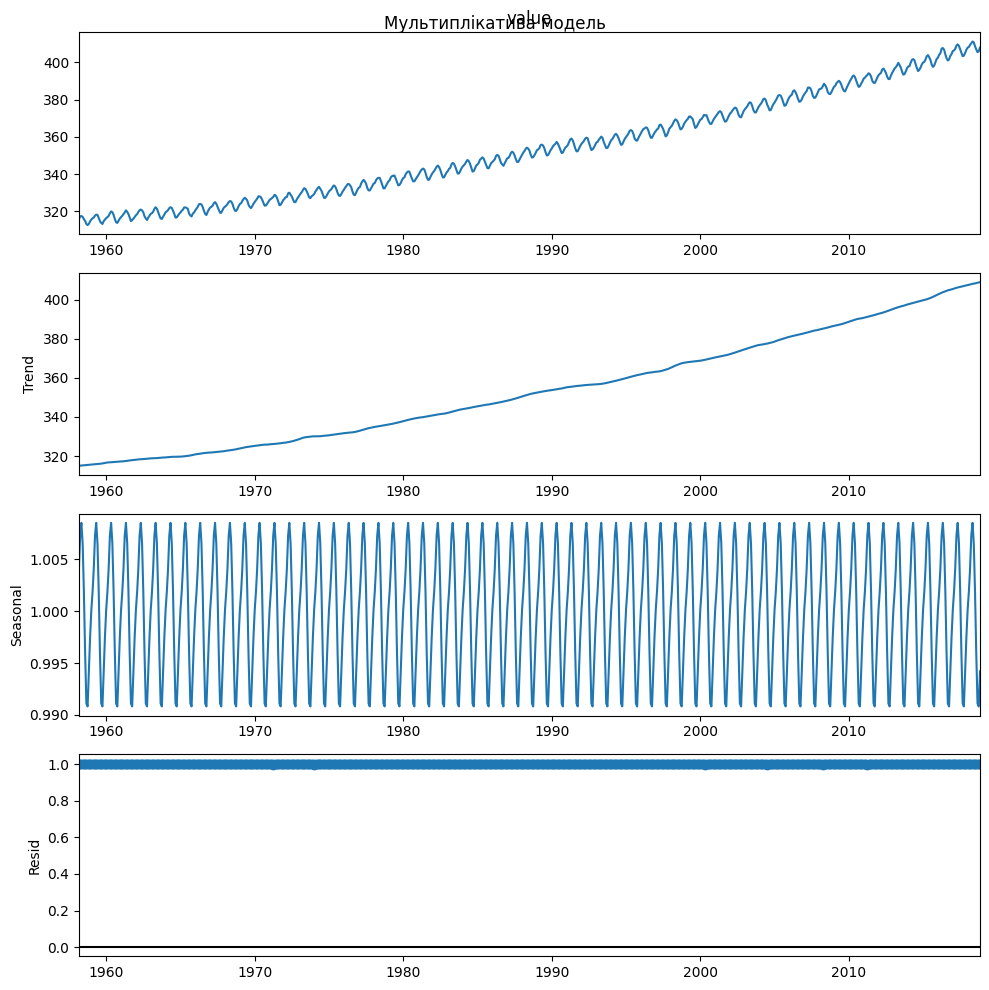

In [8]:
# декомпозиция 
result_M = seasonal_decompose(df.value, model='multiplicative', extrapolate_trend=12)

# Построение графика
plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Мультиплікатива модель')

In [9]:
result = sm.tsa.stattools.adfuller(df, autolag='AIC')
print(f'ADF-statistics: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical values:')
    print(f'{key}, {value}')

ADF-statistics: 4.994847244403913
p-value: 1.0
Critical values:
1%, -3.439620010600208
Critical values:
5%, -2.8656309041017756
Critical values:
10%, -2.5689484851894413


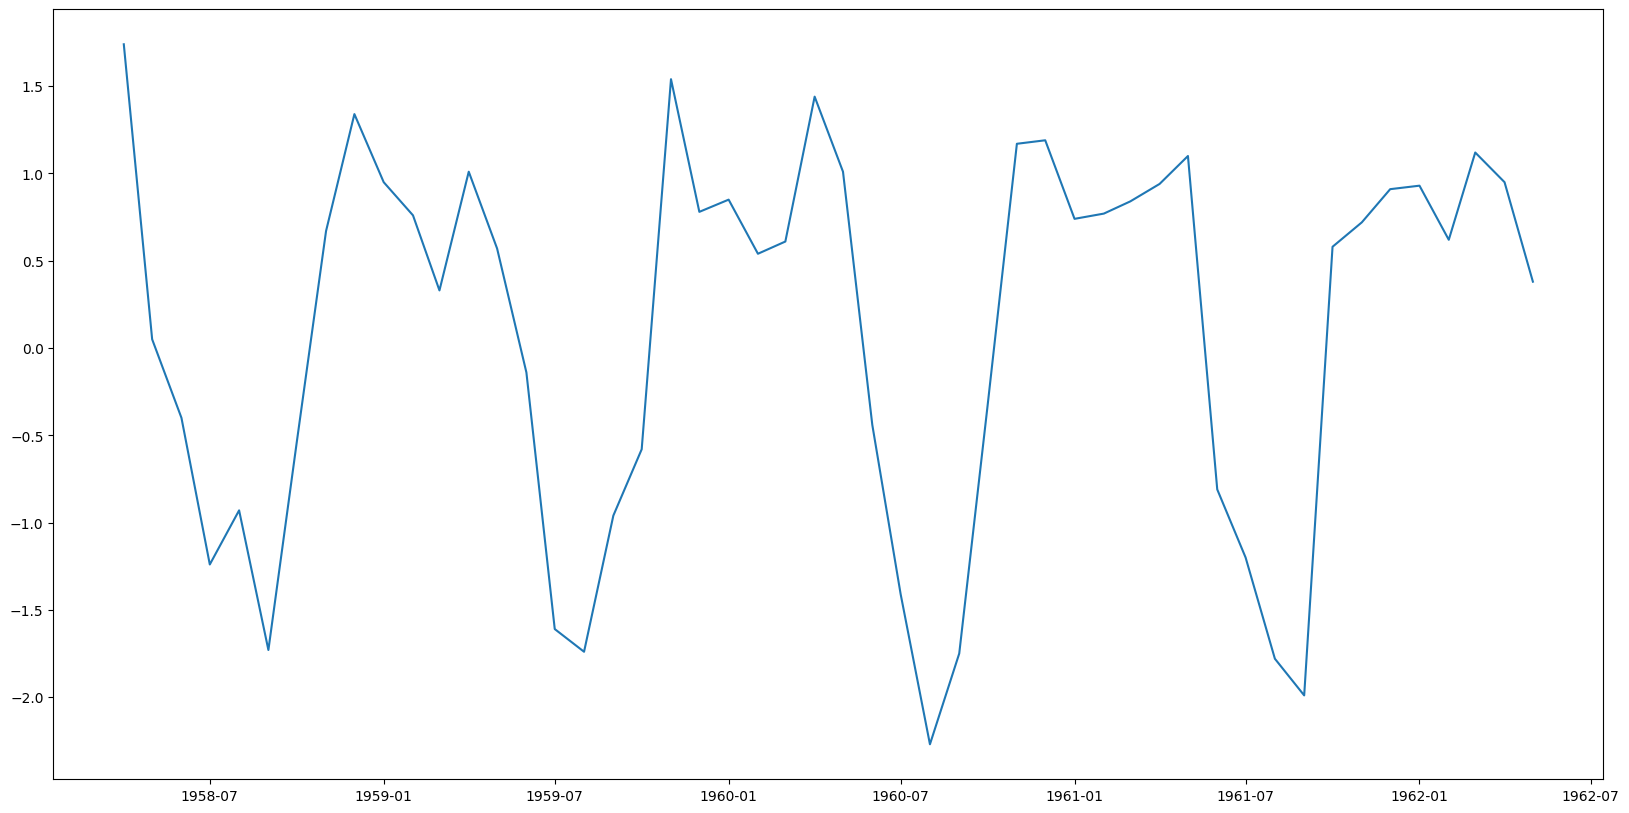

In [10]:
detrended = df.diff()[1:]
plt.figure(figsize=(20, 10))
plt.plot(detrended[0:50])

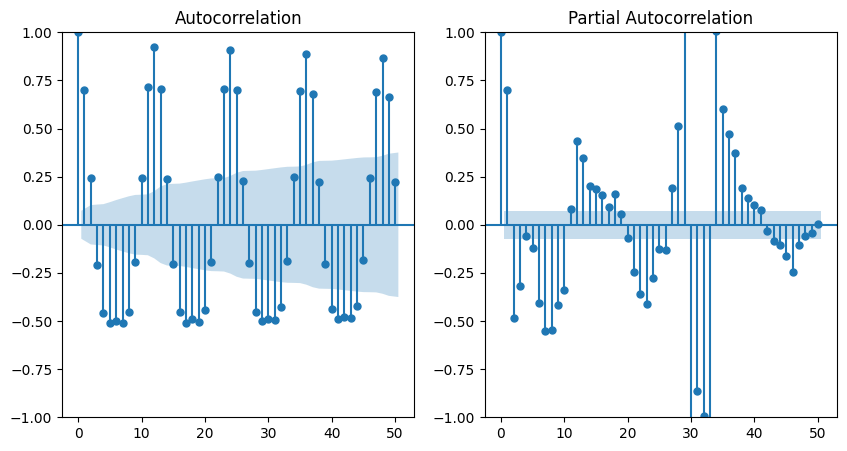

In [11]:
fig, axes = plt.subplots(1, 2,figsize=(10, 5), dpi= 100)
plot_acf(detrended, lags=50, ax=axes[0])
plot_pacf(detrended, lags=50, ax=axes[1])
plt.show()

In [12]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = ARIMA(df,
            order=param,
            seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))           
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6896.026330835386
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:5868.510106587319
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2822.10872847603
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2377.9596231941296
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1558.6042207865564
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1296.4010641956856
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1864.338786334426
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1357.406288802842
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:5896.067901833376
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:4893.823591864877
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2101.364214524755
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1884.3261540856092
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1017.6374300347754
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:950.1177239879123
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1582.5491836295182
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1055.3559181820006
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2371.0019758047247
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1756.511148011529
ARI

In [13]:
mod = ARIMA(df, 
            order=(1, 1, 1), 
            seasonal_order=(1, 1, 1, 12), 
            enforce_stationarity=False, 
            enforce_invertibility=False) 
results = mod.fit()

In [14]:
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.1707,0.084,2.038,0.042,0.007,0.335
ma.L1,-0.5360,0.073,-7.307,0.000,-0.680,-0.392
ar.S.L12,-0.0005,0.000,-1.624,0.104,-0.001,9.83e-05
ma.S.L12,-0.8671,0.021,-41.951,0.000,-0.908,-0.827
sigma2,0.0941,0.005,20.328,0.000,0.085,0.103


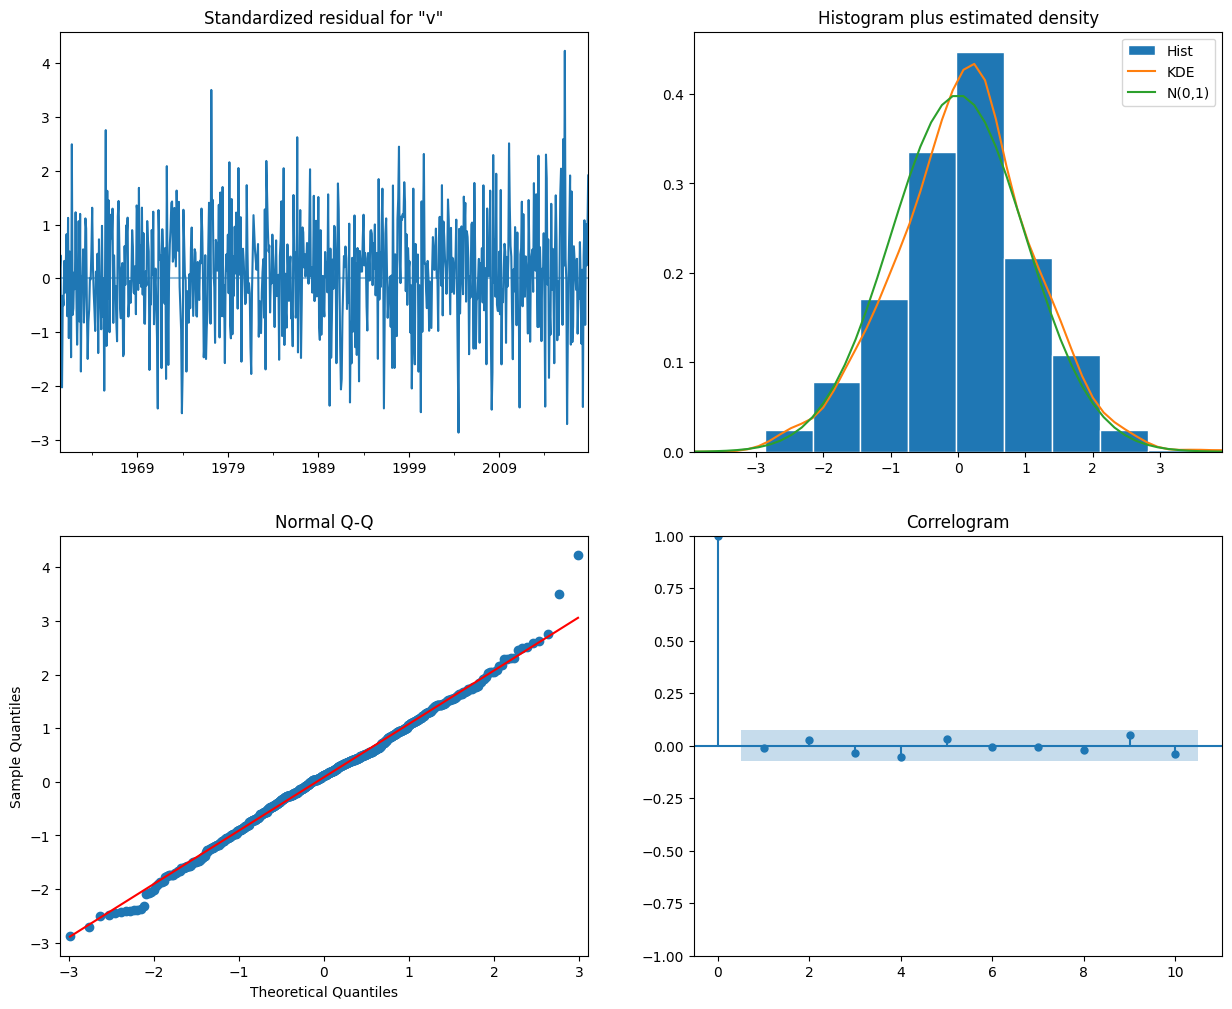

In [15]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [16]:
pred = results.get_prediction(start=pd.to_datetime('2014-08-01'), dynamic=False)
pred_ci = pred.conf_int()

Text(0, 0.5, 'Sales')

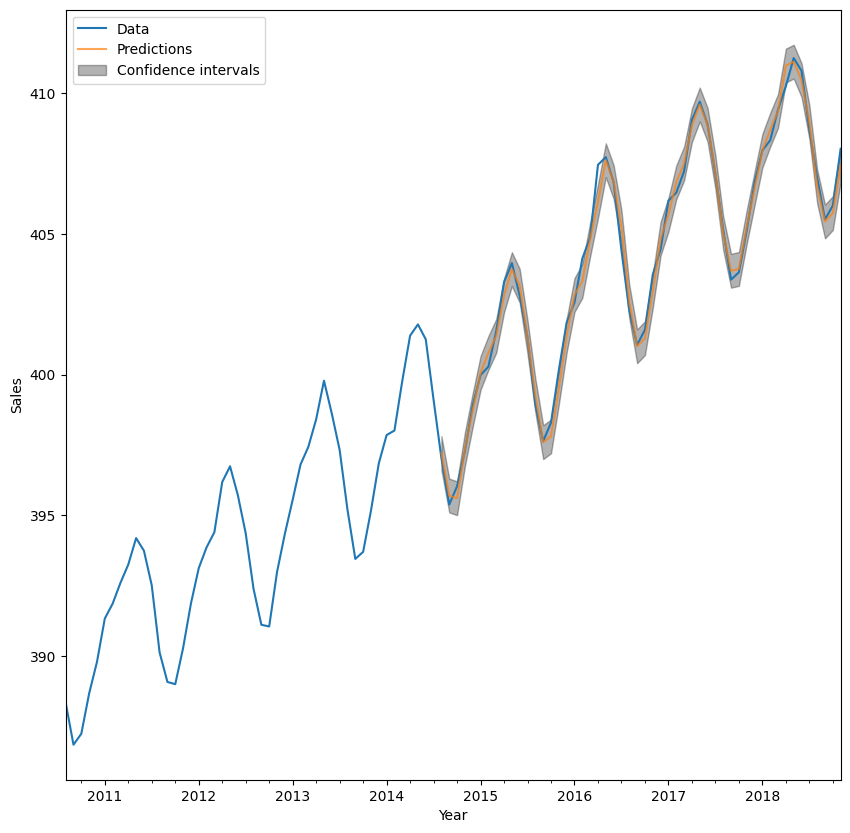

In [17]:
ax = df[len(df)-100:].plot()
pred.predicted_mean.plot(alpha=.7)
ax.fill_between(pred_ci.index, pred_ci['lower value'], pred_ci['upper value'], alpha=.3, color='k')

plt.legend(('Data', 'Predictions', 'Confidence intervals'))
ax.set_xlabel('Year')
ax.set_ylabel('Sales')

In [22]:
pred_dynamic = results.get_prediction(pd.to_datetime('2014-08-01'), dynamic=True)
pred_ci = pred.conf_int()

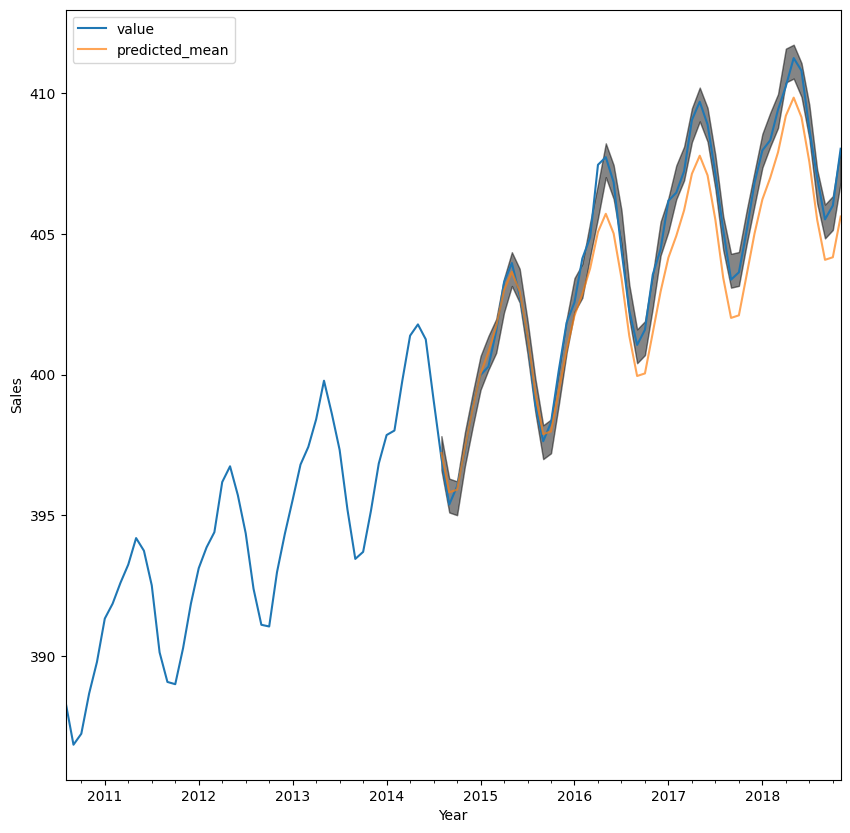

In [26]:
ax = df[len(df)-100:].plot()
pred_dynamic.predicted_mean.plot(alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_between(pred_ci.index, pred_ci['lower value'], pred_ci['upper value'], alpha=.3, color='k')
ax.set_xlabel('Year')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [18]:
df_forecasted = pred.predicted_mean
df_truth = df.value['1958-03-01':] # Обчислюємо середню квадртичну похибку
mse = ((df_forecasted - df_truth) ** 2).mean()
print('Mean squared error of predictions = {}'.format(round(mse, 2)))

Mean squared error of predictions = 0.15


In [19]:
pred_uc = results.get_forecast(steps=30)
# Отримуємо інтервал прогнозу
pred_ci = pred_uc.conf_int()

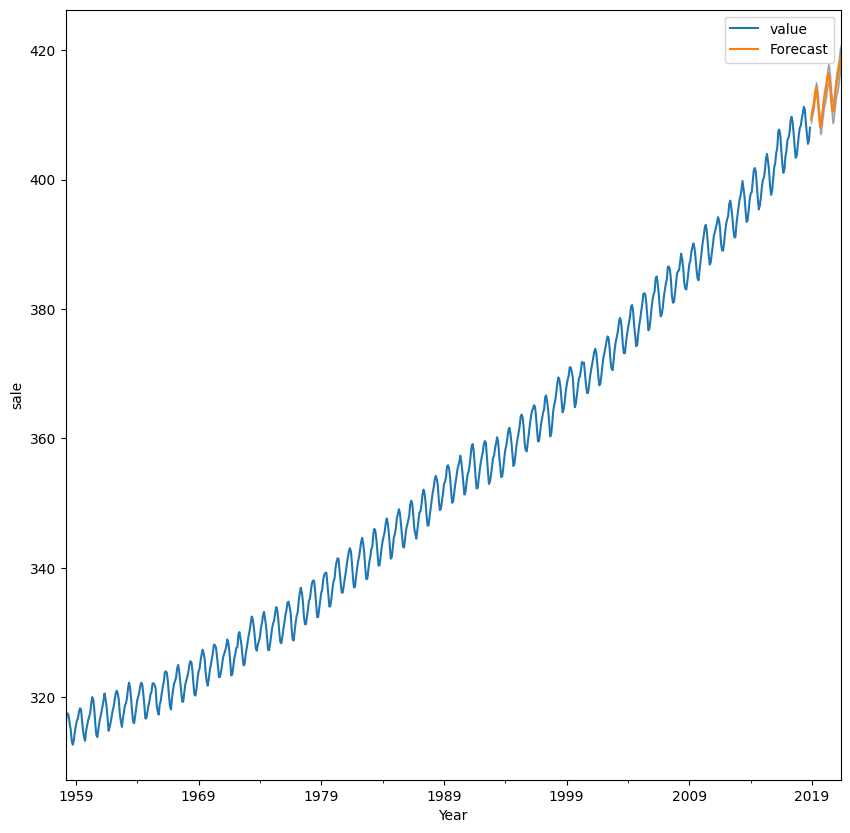

In [20]:
ax = df.plot(label='Known')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('sale')
plt.legend()
plt.show()

In [23]:
pred_ci.to_csv('prediction_results.csv')